# Online Evolutionary Collaborative Filtering Replication

## Author: Drew Brock

## CSCI 5123

- C-Level: Baseline
- B-level: Implementing all code myself
- A-level: testing on two data sets (netflix and movielens), comparing to regular collaborative filtering, comparing to model based like their related work section

"Collaborative filtering algorithms attempt to predict a user's interests based on his past feedback. In real world applications, a user's feedback is often continuously collected over a long period of time. It is very common for a user's interests or an item's popularity to change over a long period of time. Therefore, the underlying recommendation algorithm should be able to adapt to such changes accordingly. However, most existing algorithms do not distinguish current and historical data when predicting the users' current interests. In this paper, we consider a new problem - online evolutionary collaborative filtering, which tracks user interests over time in order to make timely recommendations. We extended the widely used neighborhood based algorithms by incorporating temporal information and developed an incremental algorithm for updating neighborhood similarities with new data. Experiments on two real world datasets demonstrated both improved effectiveness and efficiency of the proposed approach."

This is a memory based approach


In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import deque
import os
from matplotlib import pyplot as plt



"we removed all users and movies with age less than 1 year and then selected a subset formed by the 35,000 most active users and 4,000 most pop- ular movies as measure by their associated number of ratings. The final dataset contains around 10 million ratings. In addition to this set of ratings, we also selected another set of rating by 2000 users as validation set for tuning the various parameters such as number of neighbors k, and weight decay rate α and β."

In [3]:
# Load data for all movies
movie_titles = pd.read_csv('netflix_dataset/movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name'], on_bad_lines='skip').set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17434, 2)


,Year,Name
Id,,
5450,1997.0,Wacky Babies & Tender Times: Marty Stouffer's ...
17455,1998.0,Jeremiah: The Bible
14721,1998.0,The Bird People in China
17428,2002.0,Eye See You
14582,2000.0,Best of Travels in Europe with Rick Steves: Br...


In [4]:
#if not os.path.isfile('data.csv'):
data = open('data.csv', mode='w')

# files = ['./netflix_dataset/combined_data_1.txt',
#          './netflix_dataset/combined_data_2.txt',
#          './netflix_dataset/combined_data_3.txt',
#          './netflix_dataset/combined_data_4.txt']
files = ['./netflix_dataset/combined_data_1.txt']

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

# Read all data into a pd dataframe
df = pd.read_csv('data.csv', names=['Movie', 'User','Rating','Date'])

df

Opening file: ./netflix_dataset/combined_data_1.txt


,Movie,User,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
24053759,4499,2591364,2,2005-02-16
24053760,4499,1791000,2,2005-02-10
24053761,4499,512536,5,2005-07-27
24053762,4499,988963,3,2005-12-20


In [16]:
# turn date column into week number starting from first date indexed at 0, each following week is one more
# and for each new year the week number does not reset
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = (df['Date'] - df['Date'].min()).dt.days // 7

# remove rows with week above 296
df = df[df['Week'] < 296]

Turn date into week -> time step by weeks

custom evaluation framework

We measure the age of a movie and a user by the difference between the date of its first rating and the date of the evaluation period

"we removed all users and movies with age less than 1 year and then selected a subset formed by the 35,000 most active users and 4,000 most pop- ular movies as measure by their associated number of ratings. The final dataset contains around 10 million ratings. In addition to this set of ratings, we also selected another set of rating by 2000 users as validation set for tuning the various parameters such as number of neighbors k, and weight decay rate α and β."

We measure the age of a movie and a user by the difference between the date of its first rating and the date of the evaluation period

In [15]:
# Measure age and remove all users that made their first rating between weeks 196 and 296
user_age = df.groupby('User')['Week'].min()
# Remove all users that made their first rating between weeks 196 and 296
new_users = user_age[(user_age > 196) & (user_age < 296)].index
df = df[~df['User'].isin(new_users)]
print('Shape User-Ratings:\t{}'.format(df.shape))

# remove all movies that have their first rating between weeks 196 and 296
movie_age = df.groupby('Movie')['Week'].min()
# Remove all movies that have their first rating between weeks 196 and 296
new_movies = movie_age[(movie_age > 196) & (movie_age < 296)].index
df = df[~df['Movie'].isin(new_movies)]
print('Shape User-Ratings:\t{}'.format(df.shape))

Shape User-Ratings:	(5943051, 5)
Shape User-Ratings:	(5943051, 5)


In [7]:
# Get 35,000 most active users
user_counts = df['User'].value_counts()
# sort user counts by number of ratings
user_counts = user_counts.sort_values(ascending=False)
# get 35,000 most active users
active_users = user_counts.head(35000).index

# get 4000 most popular movies
movie_counts = df['Movie'].value_counts()
# sort movie counts by number of ratings
movie_counts = movie_counts.sort_values(ascending=False)
# get 4000 most popular movies
popular_movies = movie_counts.head(4000).index

df_filtered = df[df['User'].isin(active_users) & df['Movie'].isin(popular_movies)]
print('Shape User-Ratings:\t{}'.format(df_filtered.shape))

Shape User-Ratings:	(4649294, 5)


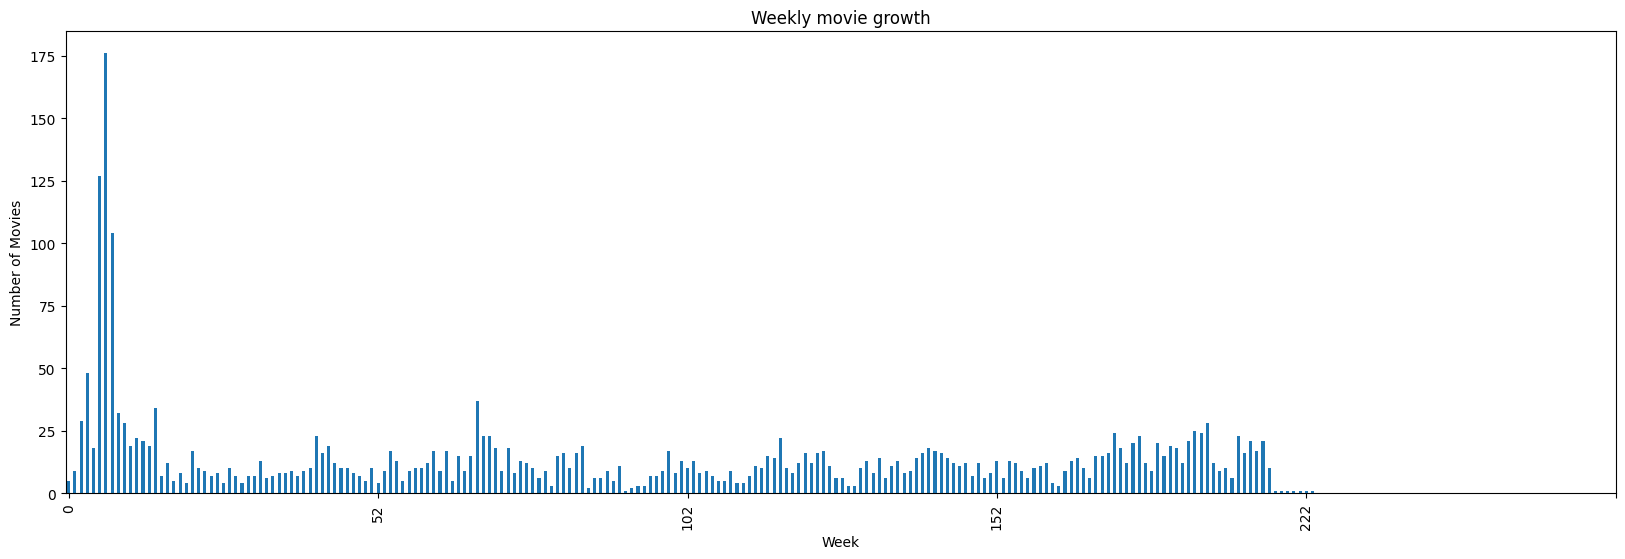

In [8]:
movie_first_rating = df_filtered.groupby('Movie')['Week'].min()
movie_first_rating = movie_first_rating.sort_values()

# count the number of movies with first rating == 0
# plot the number of movies with first rating == t for t in range(0, 296)
movie_first_rating.value_counts().sort_index().plot(kind='bar', figsize=(20, 6))
plt.xticks(range(0, 300, 50))
plt.xlabel('Week')
plt.ylabel('Number of Movies')
plt.title("Weekly movie growth")
plt.show()

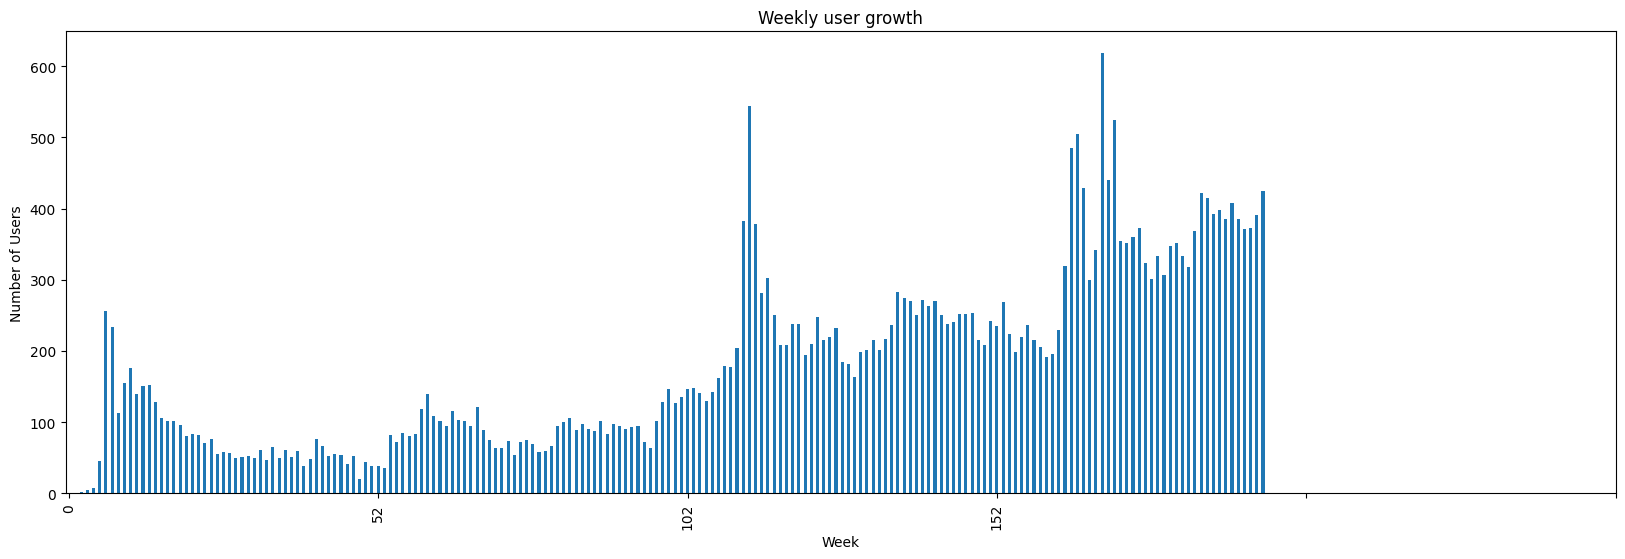

In [11]:
# weekly user growth
user_first_rating = df_filtered.groupby('User')['Week'].min()
user_first_rating = user_first_rating.sort_values()

# plot the number of users with first rating == t for t in range(0, 296)
user_first_rating.value_counts().sort_index().plot(kind='bar', figsize=(20, 6))
plt.xticks(range(0, 300, 50))
plt.xlabel('Week')
plt.ylabel('Number of Users')
plt.title("Weekly user growth")
plt.show()

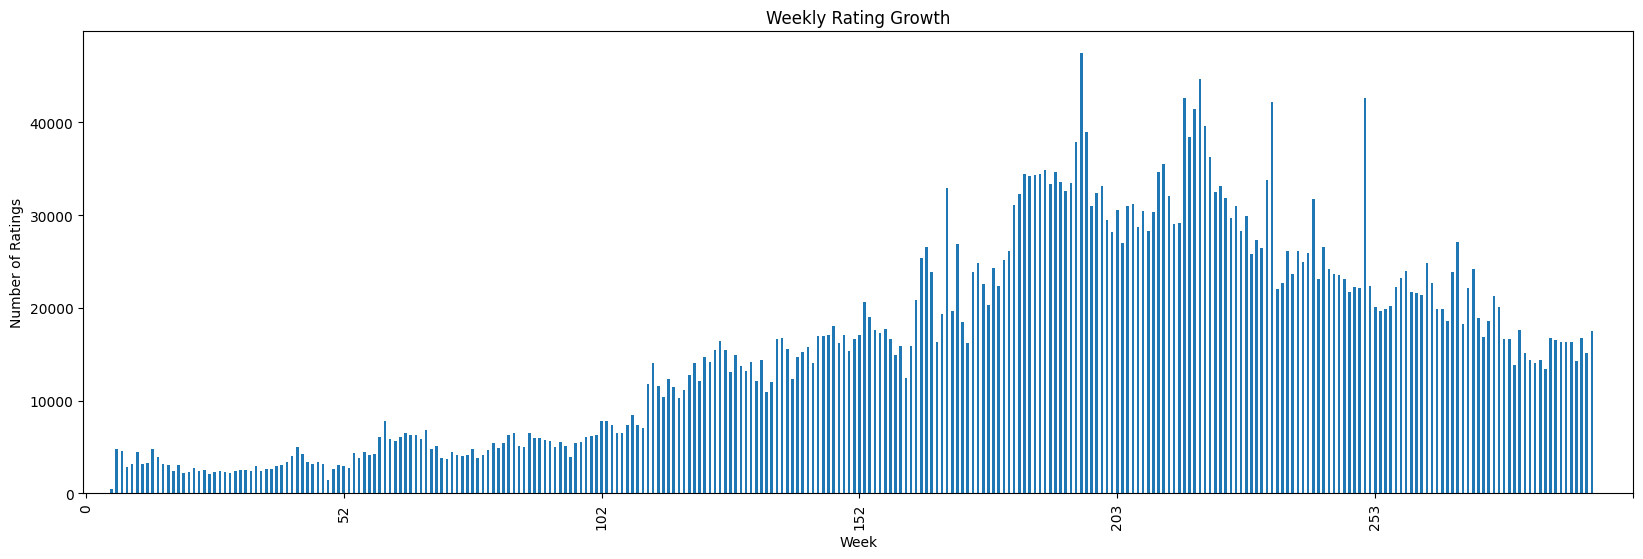

In [10]:
# Create figures of weekly movie growth, weekly user growth, and weekly rating growth
# weekly rating growth
ratings_per_week = df_filtered.groupby('Week').size()
# as bar plot
plt.figure(figsize=(20, 6))
ratings_per_week.plot(kind='bar')
plt.xticks(range(0, 350, 50))
plt.ylabel('Number of Ratings')
plt.title('Weekly Rating Growth')
plt.show()

Rating averages over time

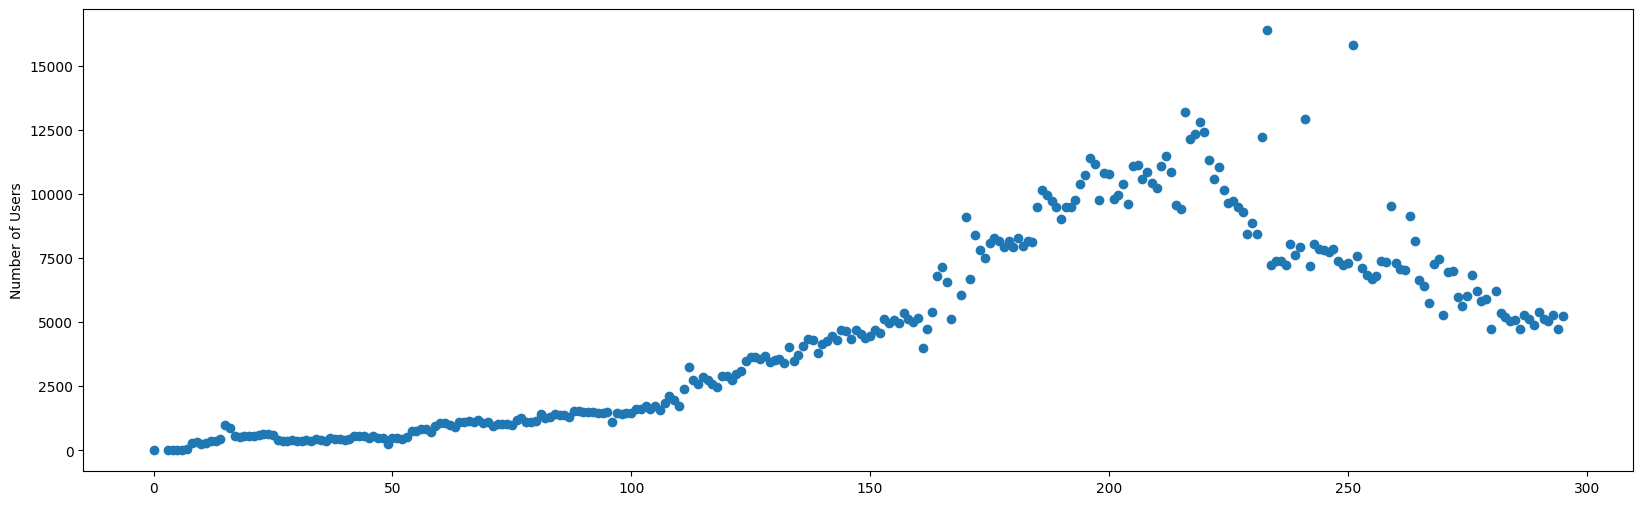

In [104]:
# number of users with first rating in each week
users_per_week = df_filtered.groupby('Week')['User'].nunique()
# as scatter plot
plt.figure(figsize=(20, 6))
plt.scatter(users_per_week.index, users_per_week)
plt.ylabel('Number of Users')
plt.show()

Two matrices, 
- Matrix R of User and Movie rating
- Matrix T of User and movie DATE of rating

In [105]:
# df_R = df_filtered.pivot_table(index='User', columns='Movie', values='Rating')
# df_T = df_filtered.pivot_table(index='User', columns='Movie', values='Week')

Evolutionary Collaborative Filtering

Step 1: Compute cosine similarity and incorporate temporal information
Under the setting of evolutionary CF, the item-item similarity is a function of time, denoted by Sij (t), which measures the similarity between two items based on their ratings on the set of users they are both rated up until time t.
To measure item similarities by incorporating temporal informa- tion, we modify the well known cosine similarity as follows

In [106]:
# this implementation creates the whole similarity matrix at once
def cosine_similarity_T(df_filtered, t, alpha=0.01):
    df_time = df_filtered[df_filtered['Week'] < t]
    df_R = df_time.pivot_table(index='User', columns='Movie', values='Rating')
    df_t = df_time.pivot_table(index='User', columns='Movie', values='Week')
    similarity_matrix = pd.DataFrame(index=df_R.columns, columns=df_R.columns)

    for i, movie1 in enumerate(df_R.columns):
        movie1_user_ratings = df_R[movie1].values
        movie1_user_times = df_t[movie1].values
        #get the set of users that have rated movie1 with df_t values less than t
        users_1 = movie1_user_times < t
        movie1_user_ratings = movie1_user_ratings[users_1]
        movie1_user_times = movie1_user_times[users_1]
        for j, movie2 in enumerate(df_R.columns[:i+1]):  # Only iterate over the upper triangular part of the matrix
            if i == j:
                similarity_matrix.loc[movie1, movie2] = 1
            else:
                movie2_user_ratings = df_R[movie2].values
                movie2_user_times = df_t[movie2].values
                #get the set of users that have rated movie2 with df_t values less than t
                users_2 = movie2_user_times < t
                movie2_user_ratings = movie2_user_ratings[users_2]
                movie2_user_times = movie2_user_times[users_2]
                users = np.logical_and(users_1, users_2)

                if np.any(users):
                    movie1_user_ratings = df_R[movie1].values[users]
                    movie1_user_times = df_t[movie1].values[users]
                    movie2_user_ratings = df_R[movie2].values[users]
                    movie2_user_times = df_t[movie2].values[users]

                    temporal_i = np.exp(-alpha * (t - movie1_user_times))
                    temporal_j = np.exp(-alpha * (t - movie2_user_times))

                    dot_product = np.sum(temporal_i * movie1_user_ratings * temporal_j * movie2_user_ratings)
                    norm_sum = np.sqrt(np.sum((temporal_i * movie1_user_ratings) ** 2) * np.sum((temporal_j * movie2_user_ratings) ** 2))
                    if dot_product == 0 or norm_sum == 0:
                        similarity_matrix.loc[movie1, movie2] = 0
                        similarity_matrix.loc[movie2, movie1] = 0
                    else:
                        similarity_matrix.loc[movie1, movie2] = dot_product / norm_sum
                        similarity_matrix.loc[movie2, movie1] = similarity_matrix.loc[movie1, movie2]  # Symmetric element

    return df_R, df_t, similarity_matrix


In [107]:
dfr, dft, similarity_m = cosine_similarity_T(df_filtered, 100)
similarity_m

Movie,7,12,15,16,18,20,29,31,41,43,...,4474,4478,4479,4481,4482,4483,4488,4494,4496,4498
Movie,,,,,,,,,,,,,,,,,,,,,
7,1,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,...,0.994626,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0
12,NaN,1,1.0,0.95316,0.891523,NaN,NaN,0.934086,NaN,NaN,...,0.82003,0.932816,0.849009,NaN,0.980197,NaN,0.850491,NaN,0.82423,NaN
15,NaN,1.0,1,NaN,0.93996,NaN,1.0,1.0,1.0,NaN,...,0.987665,NaN,0.988671,NaN,0.963651,NaN,NaN,NaN,0.833679,1.0
16,1.0,0.95316,NaN,1,0.889005,NaN,NaN,0.983197,1.0,1.0,...,0.87893,0.905945,0.853866,NaN,0.846267,0.956903,0.93045,NaN,0.903225,NaN
18,NaN,0.891523,0.93996,0.889005,1,NaN,1.0,0.866533,0.984253,0.999484,...,0.906919,0.897724,0.92079,1.0,0.841367,0.904176,0.926539,NaN,0.930427,0.978648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,NaN,NaN,NaN,0.956903,0.904176,NaN,NaN,NaN,NaN,NaN,...,0.890284,0.877203,0.854516,NaN,0.908433,1,0.92269,NaN,0.909976,1.0
4488,NaN,0.850491,NaN,0.93045,0.926539,NaN,NaN,1.0,NaN,NaN,...,0.852392,0.930015,0.940858,1.0,0.901601,0.92269,1,NaN,0.917768,0.898248
4494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,1.0,1.0,NaN,0.986722,NaN,NaN,1,NaN,NaN


Score prediction WITH a precomputed similarity matrix

In [17]:
def score_prediction(user, movie, t, similarity_matrix, df_R, df_t, beta=0.01, k=10):
    # rating predictions as a weighted average of the ratings on the subset of i’s nearest neighbors which have been rated by u
    user_average = df_R.loc[user].mean()
    s_KNN = similarity_matrix.loc[movie].sort_values(ascending=False)
    # subset of s_KNN that have been rated by user
    s_KNN = s_KNN[df_R.loc[user].notna()].head(k)
    # for each movie in s_KNN, get the rating of user
    user_times = df_t.loc[user][s_KNN.index]
    temporal = np.exp(-beta * (t - user_times))

    numerator = np.sum(temporal * s_KNN * df_R.loc[user][s_KNN.index])
    denominator = np.sum(np.abs(temporal * s_KNN))
    if denominator == 0:
        return user_average
    else:
        return user_average + numerator / denominator
#score_prediction(305344, 79, 100, similarity_m, dfr, dft)


The following three cells are fairly inefficient for any widescale user, good for simple one time predictions for a user. This was a part of my attempt to implement the incremental computation.

In [109]:
# get the similarity between two movies, implement the algorithm to get the similarity between two movies
def get_similarity_OTF(df_R, df_t, t, movie1, movie2, alpha=0.01):
    if movie1 == movie2:
        return 1
    movie1_user_ratings = df_R[movie1].values
    movie1_user_times = df_t[movie1].values
    #get the set of users that have rated movie1 with df_t values less than t
    users_1 = movie1_user_times < t
    movie1_user_ratings = movie1_user_ratings[users_1]
    movie1_user_times = movie1_user_times[users_1]

    movie2_user_ratings = df_R[movie2].values
    movie2_user_times = df_t[movie2].values
    #get the set of users that have rated movie2 with df_t values less than t
    users_2 = movie2_user_times < t
    movie2_user_ratings = movie2_user_ratings[users_2]
    movie2_user_times = movie2_user_times[users_2]
    users = np.logical_and(users_1, users_2)

    if np.any(users):
        movie1_user_ratings = df_R[movie1].values[users]
        movie1_user_times = df_t[movie1].values[users]
        movie2_user_ratings = df_R[movie2].values[users]
        movie2_user_times = df_t[movie2].values[users]

        temporal_i = np.exp(-alpha * (t - movie1_user_times))
        temporal_j = np.exp(-alpha * (t - movie2_user_times))

        dot_product = np.sum(temporal_i * movie1_user_ratings * temporal_j * movie2_user_ratings)
        norm_sum = np.sqrt(np.sum((temporal_i * movie1_user_ratings) ** 2) * np.sum((temporal_j * movie2_user_ratings) ** 2))

        return dot_product / norm_sum
    else:
        return np.nan



In [110]:
# predict the rating of a user for a movie using the temporal collaborative filtering
def score_prediction_OTF(user_id, movie_id, df_R, df_T, t, beta=0.01, k = 10):
    # get the set of nearest neighbors of item i  at time t (compute similarity between i and all other items then get top k)
    similarity = pd.Series(index=df_R.columns)
    for movie in df_R.columns:
        similarity[movie] = get_similarity_OTF(df_R, df_T, t, movie_id, movie)
    nearest_neighbors = similarity.iloc[:k].index
    # get the subset of nearest neighbors that user u has rated
    user_ratings = df_R.loc[user_id, nearest_neighbors].dropna()

    # for j in user_ratings, get the similarity between movie i and movie j
    similarities = similarity.loc[user_ratings.index]
    # get the temporal factor
    user_times = df_T.loc[user_id, user_ratings.index]
    temporal = np.exp(-beta * (t - user_times))
    # predict the rating of user u for movie i
    denominator = np.sum(similarities * temporal)
    if denominator == 0:
        return 0
    average_rating = np.mean(df_R.loc[user_id].dropna())
    prediction = average_rating + np.sum(similarities * user_ratings * temporal) / denominator
    return prediction

def choice_prediction(user_id, movie_id, df_R, df_T, t, beta=0.01, k = 10):
    # get the set of nearest neighbors of item i  at time t (compute similarity between i and all other items then get top k)
    similarity = pd.Series(index=df_R.columns)
    for movie in df_R.columns:
        similarity[movie] = get_similarity_OTF(df_R, df_T, t, movie_id, movie)
    # sort the similarity values in descending order and get the top k
    similarity = similarity.sort_values(ascending=False)
    nearest_neighbors = similarity.iloc[:k].index
    # compute with all nearest_neighbors, not just the ones that user u has rated
    user_ratings = df_R.loc[user_id, nearest_neighbors]

    similarities = similarity.loc[user_ratings.index]
    user_times = df_T.loc[user_id, user_ratings.index]
    temporal = np.exp(-beta * (t - user_times))
    # predict the rating of user u for movie i
    denominator = np.sum(similarities * temporal)
    if denominator == 0:
        return 0
    prediction = np.sum(similarities * user_ratings * temporal) / denominator
    return prediction



Evaluation Framework for Item Prediction

In [111]:
# Measure the performance of the algorithm with RMSE
T = 100
# train data
df_train = df_filtered[df_filtered['Week'] < T]
# test data
df_test = df_filtered[df_filtered['Week'] == T]
df_test = df_test[df_test['User'].isin(df_train['User']) & df_test['Movie'].isin(df_train['Movie'])]

train_similarities = cosine_similarity_T(df_train, T, alpha = 0.06)
dfr = train_similarities[0]
dft = train_similarities[1]
similarity_m = train_similarities[2]

predictions = []
# for all ratings in the test data, predict the rating and store it in the predictions list with the actual rating
for index, row in df_test.iterrows():
    user = row['User']
    movie = row['Movie']
    rating = row['Rating']
    prediction = score_prediction(user, movie, T, similarity_m, dfr, dft, beta=0)
    predictions.append((rating, prediction))

# Test Driver

Hardware: M1 Macbook Pro with 16gb of RAM

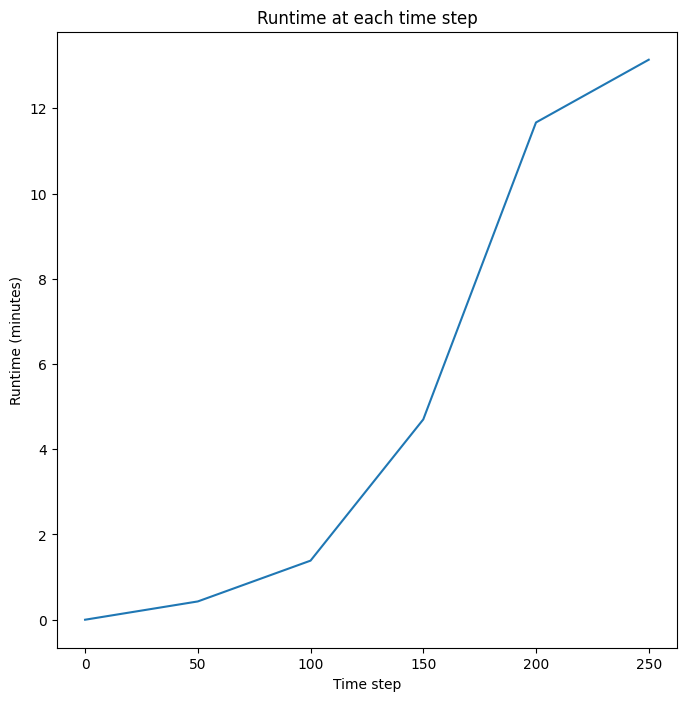

In [112]:
# time how long it takes to run the function in minutes over multiple values of t and plot the results
from time import time
t_values = np.arange(0, 300, 50)
times = []
for t in t_values:
    start = time()
    cosine_similarity_T(df_filtered, t)
    times.append((time() - start) / 60 )


plt.figure(figsize=(8, 8))
plt.ylabel('Runtime (minutes)')
plt.xlabel("Time step")
plt.title("Runtime at each time step")
plt.plot(t_values, times)

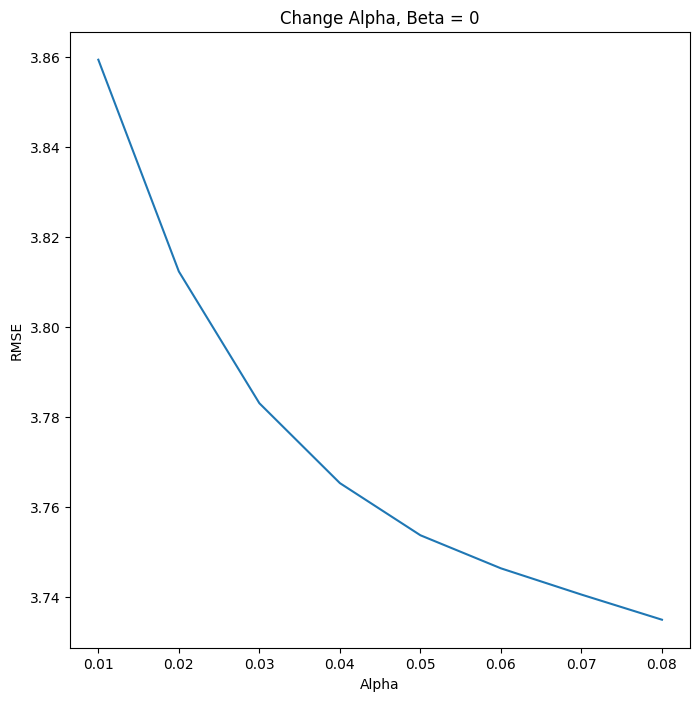

In [113]:
# for alpha in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08] and beta = 0, compute the RMSE
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
rmse_L = []
for alpha in alphas:
    train_similarities = cosine_similarity_T(df_train, T, alpha=alpha)
    dfr = train_similarities[0]
    dft = train_similarities[1]
    similarity_m = train_similarities[2]
    predictions = []
    for index, row in df_test.iterrows():
        user = row['User']
        movie = row['Movie']
        rating = row['Rating']
        prediction = score_prediction(user, movie, T, similarity_m, dfr, dft, beta=0)
        predictions.append((rating, prediction))
    rmse_L.append(np.sqrt(np.mean([(rating - prediction) ** 2 for rating, prediction in predictions])))

plt.figure(figsize=(8, 8))
plt.ylabel('RMSE')
plt.xlabel("Alpha")
plt.title("Change Alpha, Beta = 0")
plt.plot(alphas, rmse_L)

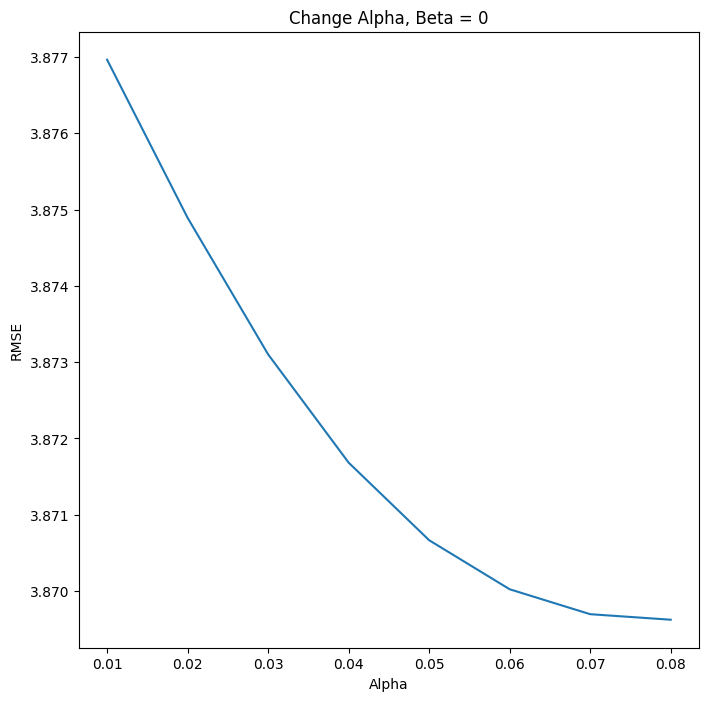

In [114]:
# for beta in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08] and alpha = 0, compute the RMSE
betas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
rmse_L2 = []
for beta in betas:
    train_similarities = cosine_similarity_T(df_train, T, alpha=0)
    dfr = train_similarities[0]
    dft = train_similarities[1]
    similarity_m = train_similarities[2]
    predictions = []
    for index, row in df_test.iterrows():
        user = row['User']
        movie = row['Movie']
        rating = row['Rating']
        prediction = score_prediction(user, movie, T, similarity_m, dfr, dft, beta=beta)
        predictions.append((rating, prediction))
    rmse_L2.append(np.sqrt(np.mean([(rating - prediction) ** 2 for rating, prediction in predictions])))

plt.figure(figsize=(8, 8))
plt.ylabel('RMSE')
plt.xlabel("Beta")
plt.title("Change Beta, Alpha = 0")
plt.plot(betas, rmse_L2)

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


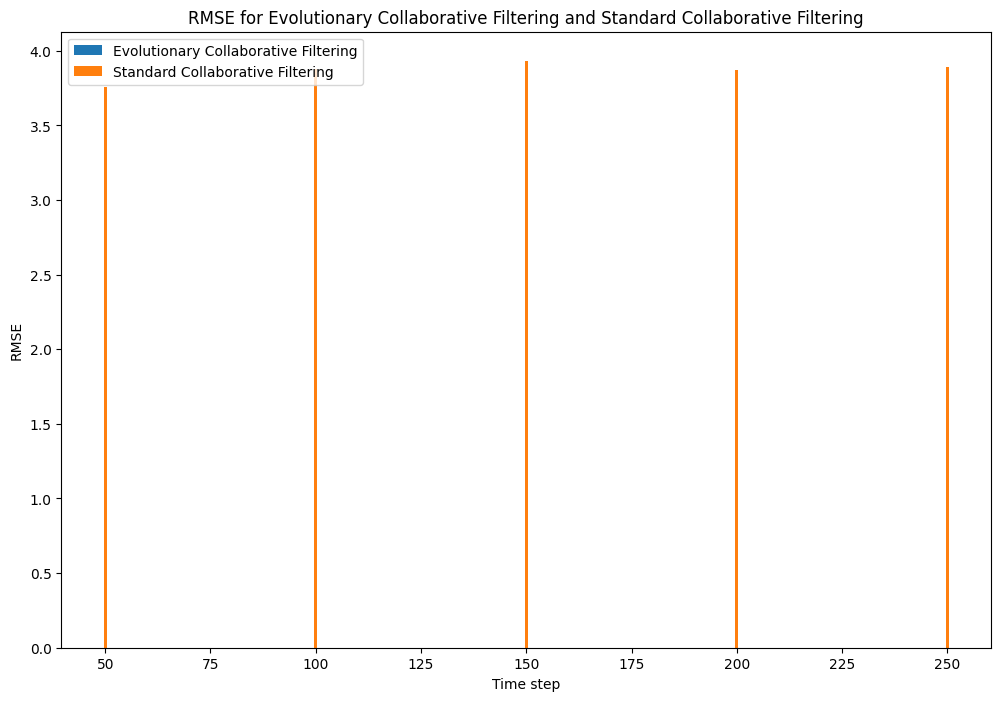

In [115]:
rmse_Pl = []
rmse_sNN = []
for val in t_values:
    df_train = df_filtered[df_filtered['Week'] < val]
    # test data
    df_test = df_filtered[df_filtered['Week'] == val]
    df_test = df_test[df_test['User'].isin(df_train['User']) & df_test['Movie'].isin(df_train['Movie'])]

    train_similarities = cosine_similarity_T(df_train, val, alpha = 0.06)
    sNN_similarities = cosine_similarity_T(df_train, val, alpha = 0)
    dfr = train_similarities[0]
    dfr_sNN = sNN_similarities[0]
    dft = train_similarities[1]
    dft_sNN = sNN_similarities[1]
    similarity_m = train_similarities[2]
    sNN_sim_m = sNN_similarities[2]

    predictions = []
    pre2 = []
    # for all ratings in the test data, predict the rating and store it in the predictions list with the actual rating
    for index, row in df_test.iterrows():
        user = row['User']
        movie = row['Movie']
        rating = row['Rating']
        prediction1 = score_prediction(user, movie, val, similarity_m, dfr, dft)
        prediction2 = score_prediction(user, movie, val, sNN_sim_m, dfr_sNN, dft_sNN, beta=0)
        predictions.append((rating, prediction1))
        pre2.append((rating, prediction2))
    rmse_Pl.append(np.sqrt(np.mean([(rating - prediction) ** 2 for rating, prediction in predictions])))
    rmse_sNN.append(np.sqrt(np.mean([(rating - prediction) ** 2 for rating, prediction in pre2])))

plt.figure(figsize=(12, 8))
plt.ylabel('RMSE')
plt.xlabel("Time step")
plt.title("RMSE for Evolutionary Collaborative Filtering and Standard Collaborative Filtering")

bar_width = 3  # Increase this value to make the bars thicker
t_values_np = np.array(t_values)

# Remove the offset to make the bars right next to each other
plt.bar(t_values_np - bar_width, rmse_Pl, bar_width, label='Evolutionary Collaborative Filtering', align='edge')
plt.bar(t_values_np, rmse_sNN, bar_width, label='Standard Collaborative Filtering', align='edge')

plt.legend()
plt.show()

In [1]:
plt.figure(figsize=(12, 8))
plt.ylabel('RMSE')
plt.xlabel("Time step")
plt.title("RMSE for Evolutionary Collaborative Filtering and Standard Collaborative Filtering")

bar_width = 3  # Increase this value to make the bars thicker
t_values_np = np.array(t_values)

# Remove the offset to make the bars right next to each other
plt.bar(t_values_np - bar_width, rmse_Pl, bar_width, label='Evolutionary Collaborative Filtering', align='edge')
plt.bar(t_values_np, rmse_sNN, bar_width, label='Standard Collaborative Filtering', align='edge')

plt.legend()
plt.show()

NameError: name 'plt' is not defined

# Reference

Nathan N. Liu, Min Zhao, Evan Xiang, and Qiang Yang. 2010. Online evolutionary collaborative filtering. In Proceedings of the fourth ACM conference on Recommender systems (RecSys '10). Association for Computing Machinery, New York, NY, USA, 95–102. https://doi.org/10.1145/1864708.1864729